## Decider agent

## Setup

### Setup paths

* Add necessary imports for Google Drive which will be the working directory.
* Change the paths according to where your dataset is.

In [ ]:
from google.colab import drive
import sys, os

#mount google drive
drive.mount('/content/drive', force_remount=False)
# Change folder path so it corresponds to your environment
# COLAB_PATH = '/content/drive/My Drive/'
# change directory to the path above
#os.chdir(COLAB_PATH)

Mounted at /content/drive


### Install libraries

Install relevant libraries.

In [ ]:
!pip install stats
!pip install pymysql

     |████████████████████████████████| 127 kB 9.7 MB/s 
  Created wheel for stats: filename=stats-0.1.2a0-py3-none-any.whl size=24297 sha256=e1e9637dfac61b1b65e87780aacfcb0d08afcd36045423389ce3b4794e10bb67
  Stored in directory: /root/.cache/pip/wheels/e3/1c/58/620049eecc13fb5b4920470895e07a39f86e889a0a58b11976
Successfully built stats
     |████████████████████████████████| 43 kB 1.3 MB/s 


### Import libraries

In [ ]:
#libraries for general purpose
import requests
import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns
import time
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
import calendar
import warnings
import json
import seaborn as sns
from sqlalchemy import create_engine
warnings.filterwarnings(action='ignore')

In [ ]:
#libraries for decider agent
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import scipy.stats as st
%matplotlib inline

### Create sql alchemy engine

It is used to establish the access to the NUS data library. Regarding NUS data library, please ask to Reshma who is the manager of the database. About the details, pls ask to the administrator of data library at Fintech Lab.

In [ ]:
# create sqlalchemy engine
sqlEngine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"
                       .format(user="xxxxxx",
                               pw="xxxxxx",
                               db="xxxxxx",
                               host = 'xxx.xxx.xxx.xxx',
                               port = xxxxx))

## Guide and explanation for the agent

### 1.Overall function

* The decider agent receives daily buy/sell trading signals from quantitative agent (SMA and Bollinger Bands) and qualitative agent (Twitter sentiment strategy).

* Also, the decider agent receives daily 3 macroeconomic factor data calculated by the macro economist agent. Then, the decider creates the final recommendation based on signaling agents, macro economic factors, and CBR's case retrieval.

* Finally, the CEO agent will receive the final recommendation from the decider agent to take final action.

### 2.Logic of combining buy/sell decisions from 3 different agents

First, the Decider agent receives buy/sell recommendations of SMA, Bollinger Bands, and Twitter sentiment from quantitative and qualitative agents. To merge different trading signals into one final recommendation, I defined the following formula.

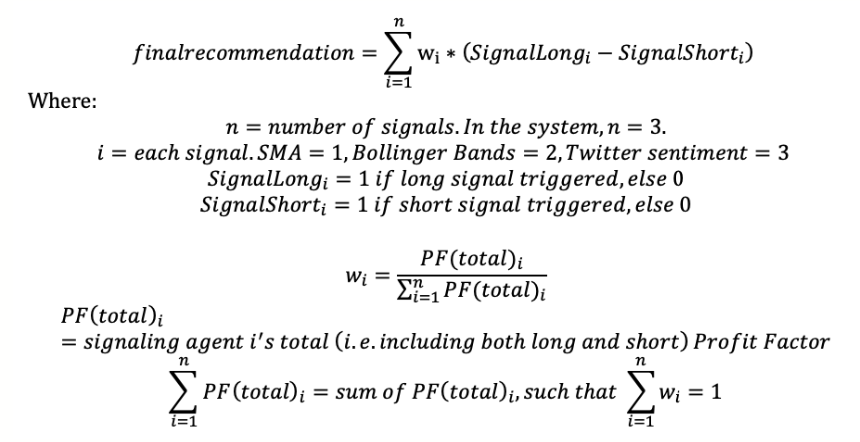

* Final recommendation is the weighted average of (SignalLong - SignalShort), in terms of the weight w calculated by the Profit Factor, which is calculated at the section of Signal PnL and Backtesting agents. 

* Above equation looks scary, but it just means that, if the Profit Factor from a certain agent is high, the weightage of this trading strategy becomes high.

 For example, in a certain day...
 
 - SMA agent has PF=2.0 (very profitable)
 - Bollinger Bands has PF=1.0 (zero profit or loss)
 - Twitter sentiment has PF=0.5 (loss is larger than profit)
 
 In this case, weightages are shown as follows:
 
 - Weightage of SMA = 2.0 / (2.0+1.0+0.5) = 0.5714
 - Weightage of Bollinger Bands = 1.0 / (2.0+1.0+0.5) = 0.2857
 - Weightage of Twitter sentiment = 0.5 / (2.0+1.0+0.5) = 0.1428
 
 Below charts shows the example of the movements for PF and weights regarding each agent (agent1=SMA, agent2=Bollinger Bands, agent3=Twitter sentiment).

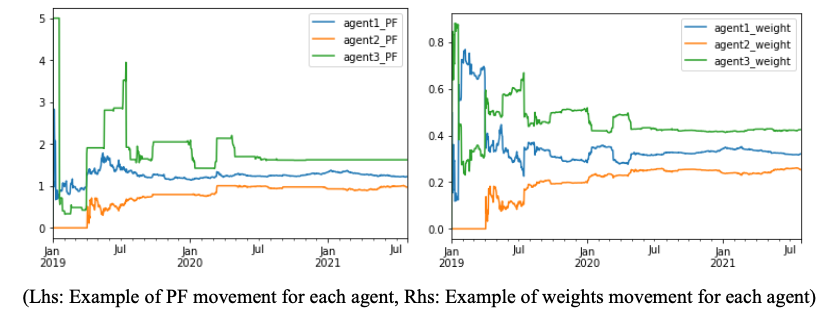

* And today, for example, if SMA shows buy, Bollinger Band shows neutral (both buy/sell signals are 0), and Twitter sentiment shows sell, then the finalrecommendation can become as follows:

 finalrecommendation = 0.5714*(1 - 0) + 0.2857*(0 - 0) + 0.1428*( 0 - 1)
 = 0.5714 + 0 - 0.1428 = 0.4286
 
* As you can infer, when all trading signals show buy recommendation, finalrecommendation is equal to 1.0, while when all trading signals show sell recommendation, finalrecommendation is equal to -1.0. Also, when all signals are neutral, finalrecommendation = 0.0.

* Then, the system convert “finalrecommendation” into 5 (strong buy), 4 (buy), 3 (neutral), 2 (sell), and 1 (strong sell) with following criteria. In above example of 0.4286, it becomes Buy (4) rating:
 - finalrecommendation > 0.5: Strong buy 5
 - 0.1 < finalrecommendation <= 0.5: Buy 4
 - 0.1 < finalrecommendation <= 0.1: Neutral 3
 - -0.5 < finalrecommendation <= -0.1: Sell 2
 - finalrecommendation <= -0.5: Strong sell 1

* Below chart shows the trading decisions made by the Decider, which reflects PF and weights for each agent shown in previous charts.

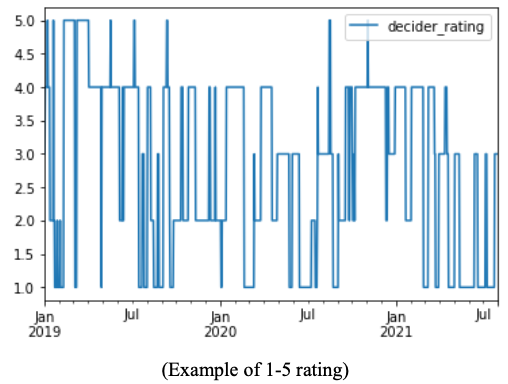

* Those calculations are implemented at the functions of def receiveSignal(agent1_hist, agent2_hist, agent3_hist),def mergeSignal(agent1_hist, agent2_hist, agent3_hist),def recommendationConverter(x), and def deciderRecommendation(allsignals_df)
in class cbrDecider(object).

### 3.Case Based Reasoning (CBR)

In the previous section, we could calculate the “final recommendation” by integrating 3 signals from SMA, Bollinger Bands, Twitter Sentiment.

However, so far, we are not sure whether the certain day’s signaling combination (e.g. SMA=buy, Bollinger=neutral, Twitter=sell in previous example) showed great performance after the day (let’s say, t+1 to t+10 days from certain day t).

Also, the performance can depend on the macroeconomic environment at a certain day t. To confirm such points, the system then applies Case Based Reasoning (CBR), with adding 3 macroeconomic factors data obtained by macro economist agent.

CBR is a relatively mature methodology in the Artificial Intelligence domain. The roots of case-based reasoning in AI is found in the works of Roger Schank and his students such as Janet Kolondner at Yale University in the early 1980s . In the 1990s, interest in CBR grew internationally, as evidenced by the establishment of an International Conference on Case-Based Reasoning in 1995.

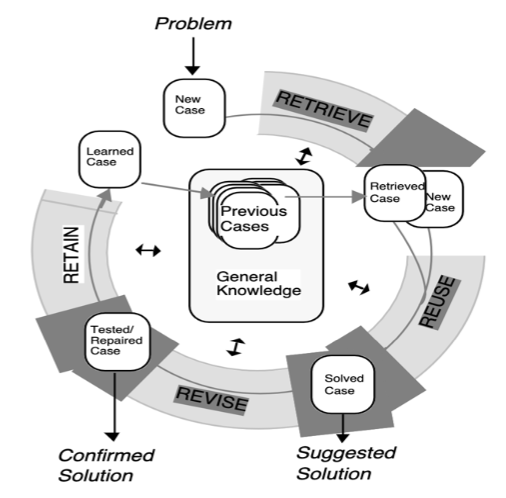

(Source: Aamodt Agnar, Enric Plaza.Case-Based Reasoning, Foundational Issues Methodological Variations and System Approaches, 1994)

Central tasks of CBR are to deal with identifying the current problem situation, finding past cases similar to the new one (Retrieve), using those similar cases to suggest a solution to the current problem (Reuse), evaluating the proposed solution (Revise), and updating the system by learning from this experience (Retain).

In the financial market, searching for “past similar market circumstances with today” to find some insights for the future is a natural way of thinking for many market practitioners. The purpose of CBR application toward algorithmic trading is to mimic such market practitioners’ methodology.

### 4.k-Nearest Neighbors (kNN)

To implement the case retrieval in CBR system, k-nearest neighbour (kNN) algorithm and its advanced application with the further improvement and/or the combination with other algorithms such as genetic algorithm (GA) are widely used. To illustrate how kNN works in the context of CBR, I implemented simple kNN this time in the system.

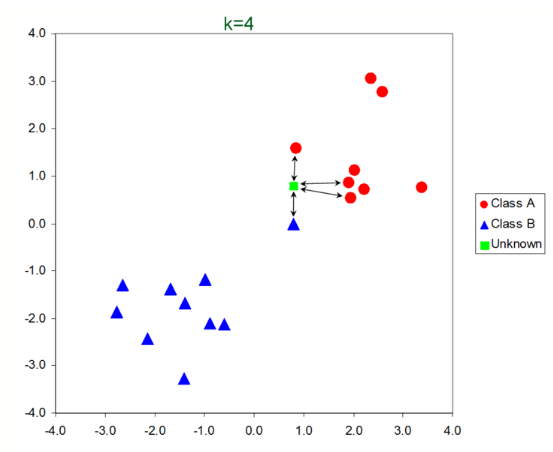

(Source:http://scholarpedia.org/article/K-nearest_neighbor) 

* K Nearest Neighbours (kNN) is the algorithm to take the distance among certain feature vectors and extract top kth nearest vectors in terms of distances.

* For example, in the above picture, k = 4, and 3 data from the red circle and 1 data from blue are taken for the new coming data of green.

* With regard to taking distance, the Minkowski distance below is popular. Especially, when we take q=2, it becomes Euclidean distance and this is popularly used in the kNN algorithm.

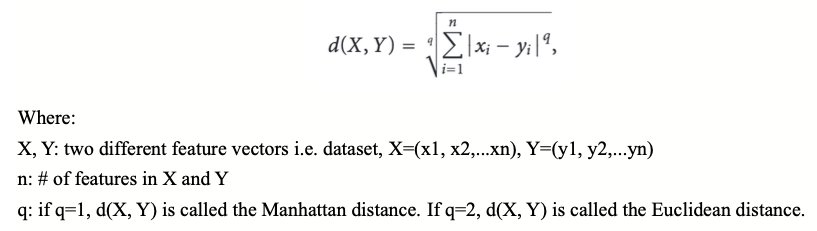

(Reference: Xiaoyuan Su and Taghi M Khoshgoftaar. A survey of collaborative filtering techniques, 2009)

* **Curse of dimensionality:** You can take note that the kNN performs better with a lower number of features. If the number of features increases, it requires more data to perform kNN appropriately. Increase in dimension of the
feature vector can also lead to the problem of overfitting. We call such problems, which is due to the higher dimension, the “Curse of dimensionality”. 

* **Reason to use PCA before kNN:** To avoid the curse of dimensionality, we often use PCA to reduce the dimensionality of data, as shown in Macro Economist agent.

### 5.Implementation of Case Retrieval in CBR by kNN

* We can apply kNN to implement the CBR of cryptocurrency trading in the same manner. In the above mentioned graph, green unknown data corresponds to today's newly coming market data. Then, the system can search k nearest past market data that correspond to red circles and blue triangulars. By doing so, the system can implement the “Retrieve” section of CBR.

* In our system, data shown below picture is stored in the past case data storage (i.e. dataframe of cbrDecider.case_data_df), and we can extract the top 30 (i.e. k=30) of the most similar datasets compared with the certain day, by using kNN.

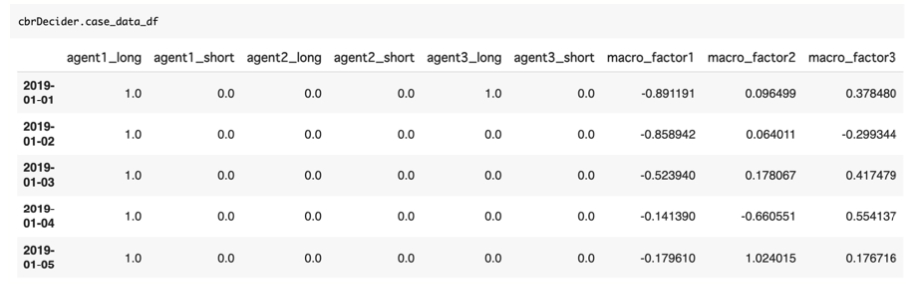

* As a result, the CBR system can obtain the data of “the most similar past market condition” in terms of the buy/sell recommendation from 3 signaling agents and the macroeconomic environment summarized by 3 macroeconomic factors. 

* To avoid the curse of dimensionality mentioned above, macroeconomic data is summarized into 3 factors, using PCA in the previous section.

* Usually, the performance of kNN can improve by the dimensionality reduction using PCA (or other methodologies of dimensionality reduction of data), such that you can utilize the combination of PCA => kNN as one of your tools in your arsenal when you implement data analytics including but not limited to the financial market data analysis.

### 6.Logic of Case Reuse, Revise, and Retain part in CBR

Next, I will show how the system implements the “Reuse” part of CBR. Whole above process is implemented at the function of def dailyReportToCEO(day, k=30, shreshold_p = 0.05) in the class cbrDecider(object).

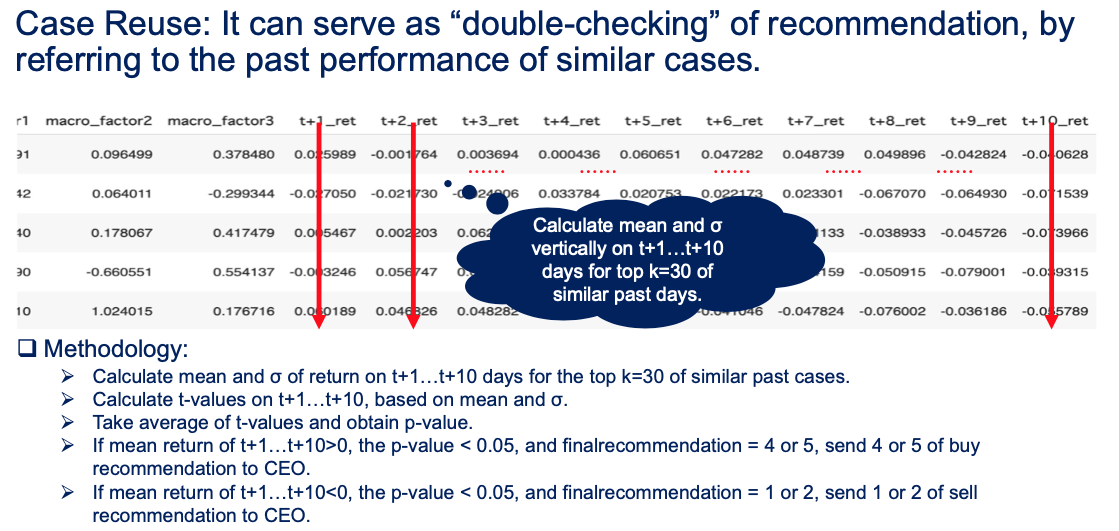

Above process means that the CBR of Reuse part can serve as the “double checking” function to confirm whether the recommendation can fit to the past actual performance in terms of the past similar cases.

After the Decider sends this double-checked recommendation to the CEO agent, the Decider agent updates the past case as of today to execute the “Revise” and “Retain” part in CBR. By doing so, new cases are updated daily such that the Decider can utilize recent cases for the next day. The function of **def caseUpdate(day)** in the **class cbrDecider(object)** is the implementation of those parts.

### Code of the agent

In [ ]:
class cbrDecider(object):

  ###################
  #Basic functions
  ###################

  #receiving signals from each signaling agent
  @staticmethod
  def receiveSignal(agent1_hist, agent2_hist, agent3_hist):
    
    signals_df_list = [agent1_hist, agent2_hist, agent3_hist]

    #extract only relevant information for decider, from each agent
    for i in range(len(signals_df_list)):
      signals_df_list[i] = signals_df_list[i][['long','short','total_PF']]
      long_column_name = 'agent' + str(i+1) + '_long'
      short_column_name = 'agent' + str(i+1) + '_short'
      PF_column_name = 'agent' + str(i+1) + '_PF'

      signals_df_list[i].columns = [long_column_name,short_column_name,
                                    PF_column_name]
    return signals_df_list

  @staticmethod
  def mergeSignal(agent1_hist, agent2_hist, agent3_hist):
    signals_df_list = cbrDecider.receiveSignal(agent1_hist, agent2_hist, agent3_hist)
    #then, merge each agents' signaling into 1 dataframe    
    allsignals_df = pd.DataFrame()
    allsignals_df = signals_df_list[0]
    for j in range(1, len(signals_df_list)):
      allsignals_df = allsignals_df.merge(signals_df_list[j], left_index=True,
                                          right_index=True, how='inner')
    
    #calculate the sum of profit factors, then calculate weight of each signals by
    #following formula:
    #weight of signal A = profit factor of signal A / sum of profit factors for all signals.
    allsignals_df['sum_PF'] = 0
    for k in range(1, len(signals_df_list)+1):
      allsignals_df['sum_PF'] = allsignals_df['sum_PF'] + allsignals_df['agent' + str(k) + '_PF']

    for m in range(1, len(signals_df_list)+1):
      #(to avoid error, adding + 0.0000000001 at denominator)
      allsignals_df['agent' + str(m) + '_weight'] = allsignals_df['agent' + str(m) + '_PF'] / \
                                                    (allsignals_df['sum_PF'] + 0.0000000001)

    #calculate the final score (-1 to 1, -1:strong sell recommendation, +1:strong buy
    #recommendation) for final decision to report CEO agent by weighted average of each signals
    allsignals_df['final_score'] = 0
    for n in range(1, len(signals_df_list)+1):
      allsignals_df['final_score'] = allsignals_df['final_score'] \
                                      + allsignals_df['agent' + str(n) + '_weight'] * allsignals_df['agent' + str(n) +'_long'] \
                                      + allsignals_df['agent' + str(n) + '_weight'] * - allsignals_df['agent' + str(n) +'_short']
    
    return allsignals_df

  #return final recommendation from 1:strong sell to 5:strong buy
  #-0.5 - -1= 1 strong sell
  #-0.1 - -0.5 = 2 sell
  #-0.1 - +0.1 = 3 neutral
  #+0.1 - +0.5 = 4 buy
  #+0.5 - +1.0 = 5 strong buy
  @staticmethod
  def recommendationConverter(x):
    if x > 0.5:
      return 5
    elif x > 0.1:
      return 4
    elif x > -0.1:
      return 3
    elif x > -0.5:
      return 2
    elif x >= -1.0:
      return 1

  #convert each agent's recommendation -> final_score into decider's recommendation
  @staticmethod
  def deciderRecommendation(allsignals_df):
    allsignals_df['decider_rating'] = allsignals_df['final_score']\
                                      .apply(cbrDecider.recommendationConverter)
    
    return allsignals_df

  #storing t+1...t+10 return of crypto on each days i.e. t+0
  #We store t+1...t+10 crypto prices for CBR's case at deciderCBR.coin_price_df
  @staticmethod
  def caseInitialization(day, training = False):

    tMinus1day = day + datetime.timedelta(days=-1)
    #price data acquisition
    coin_price_df = Broker.longHistoryPriceGetter().loc[:tMinus1day,:]

    #compute return of 1day,2days...10days. 
    for i in range(1,11):
      column_name = 't+' + str(i) + '_ret'
      coin_price_df[column_name] = coin_price_df['close'].pct_change(i)

    #shifting upward by 1 day for t+1, 2 days for t+2...10 days for t+10.
    #By doing so, t+1...t+10 columns become future t+i days' return as of t+0 day.
    for i in range(1,11):
      column_name = 't+' + str(i) + '_ret'
      coin_price_df[column_name] = coin_price_df[column_name].shift(-i)
    
    #Eliminating rows with nan
    #We store t+1...t+10 crypto prices for CBR's case at deciderCBR.coin_price_df
    coin_price_df = coin_price_df.dropna(axis=0)

    return coin_price_df

  #after updating deciderCBR.coin_price_df, decider.allsignals_df, macroEconomist.hist_pca_df,
  #unifying those data to update CBR's case data, deciderCBR.case_data_df
  @staticmethod
  def caseIntegration(coin_price_df, allsignals_df, hist_pca_df):
    coin_price_df = coin_price_df.loc[:,['t+1_ret','t+2_ret','t+3_ret','t+4_ret',
                                              't+5_ret','t+6_ret','t+7_ret','t+8_ret',
                                              't+9_ret','t+10_ret']]
    allsignals_df = allsignals_df.loc[:,['agent1_long','agent1_short',
                                          'agent2_long','agent2_short',
                                          'agent3_long','agent3_short']]
    hist_pca_df = hist_pca_df

    case_data_df = allsignals_df.merge(hist_pca_df,left_index=True,right_index=True)
    #store case data into deciderCBR.case_data_df
    case_data_df = case_data_df.merge(coin_price_df,left_index=True,right_index=True)

    return case_data_df

  ###################
  #Initialization
  #When we start trading, we run it
  ###################

  #initialization of decider
  @staticmethod
  def deciderInitialization(final_training_list, day):
    #creating signal history dataframe
    cbrDecider.signal_to_ceo_hist_df = pd.DataFrame()
    #obtain cases from training data
    agent1_hist_df = final_training_list[0][2]
    agent2_hist_df = final_training_list[1][2]
    agent3_hist_df = final_training_list[2][2]
    allsignals_df = cbrDecider.mergeSignal(agent1_hist_df, agent2_hist_df, agent3_hist_df)
    #storing signaling information into cbrDecider.allsignals_df
    cbrDecider.allsignals_df = cbrDecider.deciderRecommendation(allsignals_df)
    #initialize coin_price_df (crypto return of t+1...t+10 from t+0)
    cbrDecider.coin_price_df = cbrDecider.caseInitialization(day, training = True)
    #training period's macro data, which should be initialized before this operation
    tMinus1 = day + datetime.timedelta(days=-1)
    cbrDecider.hist_pca_df = macroEconomist.hist_pca_dfGetter().loc[:tMinus1,:]
    #case_data_df is the integration of above
    case_data_df = cbrDecider.caseIntegration(cbrDecider.coin_price_df, 
                                              cbrDecider.allsignals_df, 
                                              cbrDecider.hist_pca_df)
    #storing past case data at training period to cbrDecider.case_data_df
    cbrDecider.case_data_df = case_data_df

  ###################
  #Daily update
  ###################

  #Update tool of deciderCBR.coin_price_df
  #update this day = day's t+1...t+10 ret. It can be updated until 10 days ago
  @staticmethod
  def dailyCasePriceUpdate(day):
    tMinus10_day = day + datetime.timedelta(days=-10)

    #relevant price data acquisition
    coin_price_df = Broker.longHistoryPriceGetter().loc[tMinus10_day:day,:]

    #compute return of 1day,2days...10days. 
    for i in range(1,11):
      column_name = 't+' + str(i) + '_ret'
      coin_price_df[column_name] = coin_price_df['close'].pct_change(i)

    #shifting upward by 1 day for t+1, 2 days for t+2...10 days for t+10.
    #By doing so, t+1...t+10 columns become future t+i days' return as of t+0 day.
    for i in range(1,11):
      column_name = 't+' + str(i) + '_ret'
      coin_price_df[column_name] = coin_price_df[column_name].shift(-i)
    
    #Eliminating rows with nan
    coin_price_df = coin_price_df.dropna(axis=0)

    #update new data and store it onto cbrDecider.coin_price_df
    cbrDecider.coin_price_df = pd.concat([cbrDecider.coin_price_df, coin_price_df])

  #Update tool of deciderCBR.allsignals_df
  #We should update agent1_hist, agent2_hist, agent3_hist by quantitative / twitter agents
  #and put those into this function
  @staticmethod
  def updateSignals(day, agent1_hist, agent2_hist, agent3_hist):
    allsignals_df = cbrDecider.mergeSignal(agent1_hist, agent2_hist, agent3_hist)
    allsignals_df = cbrDecider.deciderRecommendation(allsignals_df)
    allsignals_df = allsignals_df.loc[day,:].to_frame().T

    #update new data and store it onto cbrDecider.allsignals_df
    cbrDecider.allsignals_df = pd.concat([cbrDecider.allsignals_df, allsignals_df])

  #Update macro economic data, cbrDecider.hist_pca_df
  #We should update macroEconomist.hist_pca_df, before running it
  @staticmethod
  def updateMacro(day):
    hist_pca_df = macroEconomist.hist_pca_dfGetter().loc[day,:].to_frame().T
    cbrDecider.hist_pca_df = pd.concat([cbrDecider.hist_pca_df, hist_pca_df])

  @staticmethod
  def updateNewCaseData(day):
    #store case data into deciderCBR.signal_macro_df
    cbrDecider.signal_macro_df = cbrDecider.allsignals_df.merge(cbrDecider.hist_pca_df,
                                                                left_index=True,right_index=True)

  #Case retrieval using kNN
  @staticmethod
  def dailyReportToCEO(day, k=30, shreshold_p = 0.05):

    #obtain stored case data
    train_sig_ret_df = cbrDecider.case_data_df
    #new data
    newsignal_df = cbrDecider.signal_macro_df.loc[day,:].to_frame().T
    newsignal_for_pca_df = newsignal_df.loc[:,['agent1_long','agent1_short','agent2_long',
                                 'agent2_short','agent3_long','agent3_short',
                                 'macro_factor1','macro_factor2','macro_factor3']]

    #create empty dataframe to send signal_to_ceo
    signal_to_ceo_df = pd.DataFrame(index=newsignal_df.index)
    signal_to_ceo_df['report_ceo'] = 0

    #Fit NearestNeighbors
    model = NearestNeighbors(algorithm = "brute")
    #pick up agentX_long,agentX_short, macro_factorX columns
    model_col = train_sig_ret_df.loc[:,['agent1_long','agent1_short','agent2_long',
                                 'agent2_short','agent3_long','agent3_short',
                                 'macro_factor1','macro_factor2','macro_factor3']]
    #train kNN model
    fitted = model.fit(model_col)

    ########################
    #coming new data, and find
    #k-nearest cases using kNN
    ########################

    #To each test days, we extract similar k past cases (so, using "k"-NN).
    #distance is euclidean distance (the smaller, the closer to test data)
    #indice is the set of list of past similar cases in training data.
    distance, indice = fitted.kneighbors(newsignal_for_pca_df,
                                         n_neighbors=k)
    
    #extract top k days in training data
    #we extract "same or very similar recommendation combination among 3 different
    #signaling agent with similar macro 3 factor figures".
    #Extracting same recommendation at similar macro/market circumstance is reasonable
    #to refer as past case for future decision.
    case_top_k_days_df = train_sig_ret_df.iloc[indice[0],:]
    #extract t+1 - t+10 performance of bitcoin for each similar cases from training data.
    case_top_k_days_df = case_top_k_days_df.loc[:,['t+1_ret','t+2_ret','t+3_ret','t+4_ret',
                                          't+5_ret','t+6_ret','t+7_ret','t+8_ret',
                                          't+9_ret','t+10_ret']]
    #calculate mean, std, and t-value for t+1 - t+10
    topk_ret_mean = case_top_k_days_df.mean(axis=0)
    topk_ret_std = case_top_k_days_df.std(axis=0)
    topk_ret_tval = topk_ret_mean / (topk_ret_std/np.sqrt(len(case_top_k_days_df)))

    #mean return and t-value of future t+1 - t+10
    mean_ret = topk_ret_mean.mean()
    mean_tvalue = topk_ret_tval.mean()
    #mean p-value from mean t-value
    mean_p = st.t.sf(abs(mean_tvalue), len(case_top_k_days_df)-1)

    decider_rating = newsignal_df['decider_rating'].values[0]

    #Final decision
    #if decider rating, mean_ret, mean_p shows "buy", send 4 buy or 5 strong buy 
    #to CEO.
    if ((decider_rating > 3.5) and (mean_ret > 0.0) and (mean_p < shreshold_p)):
      signal_to_ceo_df['report_ceo'].loc[day] = decider_rating
    #if decider rating, mean_ret, mean_p shows "sell", send 2 sell or 1 strong sell 
    #to CEO.
    elif ((decider_rating < 2.5) and (mean_ret < 0.0) and (mean_p < shreshold_p)):
      signal_to_ceo_df['report_ceo'].loc[day] = decider_rating
    #else (i.e. decider_rating = 3, decider_rating and mean_ret are contradictionary,
    #or p-value > shreshold_p), just send 3=neutral to CEO agent.
    else:
      signal_to_ceo_df['report_ceo'].loc[day] = 3
    
    #update and store cbrDecider.signal_to_ceo_hist_df
    if len(cbrDecider.signal_to_ceo_hist_df) == 0:
      cbrDecider.signal_to_ceo_hist_df = signal_to_ceo_df
    else:
      cbrDecider.signal_to_ceo_hist_df = pd.concat([cbrDecider.signal_to_ceo_hist_df,
                                                    signal_to_ceo_df])
      cbrDecider.signal_to_ceo_hist_df['report_ceo_diff'] = cbrDecider.signal_to_ceo_hist_df['report_ceo'].diff()

  #new case update
  @staticmethod
  def caseUpdate(day):
    tMinus10 = day + datetime.timedelta(days=-10)
    coin_price_df = cbrDecider.coin_price_df.loc[:,['t+1_ret','t+2_ret','t+3_ret','t+4_ret',
                                              't+5_ret','t+6_ret','t+7_ret','t+8_ret',
                                              't+9_ret','t+10_ret']]
    allsignals_df = cbrDecider.allsignals_df.loc[:,['agent1_long','agent1_short',
                                          'agent2_long','agent2_short',
                                          'agent3_long','agent3_short']]
    hist_pca_df = cbrDecider.hist_pca_df

    case_data_df = allsignals_df.merge(hist_pca_df,left_index=True,right_index=True)
    case_data_df = case_data_df.merge(coin_price_df,left_index=True,right_index=True)
    case_data_today_df = case_data_df.loc[tMinus10,:].to_frame().T

    cbrDecider.case_data_df = pd.concat([cbrDecider.case_data_df, case_data_today_df])

  ########################
  #Getter functions
  #Those can become interface
  #for communication among
  #different agents
  ########################
  @staticmethod
  def allSignalsGetter():
    return cbrDecider.allsignals_df

  @staticmethod
  def caseDataGetter():
    return cbrDecider.case_data_df

  @staticmethod
  def signalToCEOGetter():
    return cbrDecider.signal_to_ceo_hist_df


## Dissection of the agent

### Broker agent for price acquisition

In [ ]:
class Broker(object):

  #get whole price from SQL data library.
  @staticmethod
  def getPriceFromDataLibrary():
    dbConnection = sqlEngine.connect()
    price_df = pd.read_sql("select * from YahooData", dbConnection)
    dbConnection.close()

    price_df = price_df.set_index('Date')[['Close','Volume']]
    price_df.columns = ['close','volume']
    return price_df

  @staticmethod
  def addPctChg(df):
    df = df.copy()
    #calculate % changes
    df['pct_change'] = df['close'].pct_change()
    #In the backtesting, log return is useful, because we can calculate accumulate return %
    #just by adding daily return %. np.log1p calculate log(1+x)
    df['log_return'] = np.log1p(df['pct_change'])

    return df

  @staticmethod
  def histPriceAcquisition():
    longhist_price_df = Broker.getPriceFromDataLibrary()
    #add pct change and log_return
    longhist_price_df = Broker.addPctChg(longhist_price_df)

    #assure all 365 days are within the data index.
    startday = longhist_price_df.index[0]
    endday = longhist_price_df.index[-1]

    date_index = pd.date_range(start = startday, end = endday, freq="D").strftime('%Y-%m-%d')
    date_df = pd.DataFrame(date_index)
    date_df.columns = ['Date']
    date_df['Date'] = pd.to_datetime(date_df['Date']) 
    longhist_price_df = longhist_price_df.reset_index()
    longhist_price_df = date_df.merge(longhist_price_df, on='Date', how='outer')
    #change datetype of Date
    longhist_price_df['Date'] = longhist_price_df['Date'].astype("datetime64")
    #executing ffill (if no price is available, just filling by previous price data)
    longhist_price_df = longhist_price_df.fillna(method='ffill')
    longhist_price_df = longhist_price_df.set_index('Date')

    #Broker.longhist_price_df is created under Broker class.
    Broker.longhist_price_df = longhist_price_df[['close','volume','pct_change','log_return']]

  ########################
  #Getter functions
  ########################

  #Those can become interface
  #for communication among
  #different agents
  @staticmethod
  def longHistoryPriceGetter():
    return Broker.longhist_price_df

In [ ]:
Broker.histPriceAcquisition()

In [ ]:
df = Broker.longHistoryPriceGetter()

In [ ]:
df.head()

,close,volume,pct_change,log_return
Date,,,,
2014-09-17,457.334015,21056800.0,NaN,NaN
2014-09-18,424.440002,34483200.0,-0.071926,-0.074643
2014-09-19,394.795990,37919700.0,-0.069843,-0.072402
2014-09-20,408.903992,36863600.0,0.035735,0.035111
2014-09-21,398.821014,26580100.0,-0.024659,-0.024968


### Data acquisition

I prepared sample pnl file from SMA, bollinger band, and Twitter sentiment with csv file. Regarding how those files are created, please refer to the notebook of PnL_Backtest_agents.ipynb

In [ ]:
sma_strat_pnl_df = pd.read_csv('strategy_pnl_data/sma_strat_pnl_df.csv')
bollinger_strat_pnl_df = pd.read_csv('strategy_pnl_data/bollinger_strat_pnl_df.csv')
twitter_strat_pnl_df = pd.read_csv('strategy_pnl_data/twitter_strat_pnl_df.csv')

In [ ]:
sma_strat_pnl_df['Date'] = sma_strat_pnl_df['Date'].astype('datetime64[ns]')
bollinger_strat_pnl_df['Date'] = bollinger_strat_pnl_df['Date'].astype('datetime64[ns]')
twitter_strat_pnl_df['Date'] = twitter_strat_pnl_df['Date'].astype('datetime64[ns]')

In [ ]:
sma_strat_pnl_df.set_index('Date', inplace=True)
bollinger_strat_pnl_df.set_index('Date', inplace=True)
twitter_strat_pnl_df.set_index('Date', inplace=True)

In [ ]:
sma_strat_pnl_df.head()

,close,long_signal,short_signal,log_return,long,short,long_costprice,short_costprice,long_dailypnl_pct,short_dailypnl_pct,total_dailypnl_pct,long_dailypnl_pct_posi,long_dailypnl_pct_nega,short_dailypnl_pct_posi,short_dailypnl_pct_nega,total_dailypnl_pct_posi,total_dailypnl_pct_nega,long_sumprofit,long_sumloss,short_sumprofit,short_sumloss,total_sumprofit,total_sumloss,long_PF,short_PF,total_PF,long_cumpnl_pct_pertrade,short_cumpnl_pct_pertrade,long_cumsignal_pertrade,short_cumsignal_pertrade,long_cumpnl_pct,short_cumpnl_pct,long_recovperiod,short_recovperiod,total_recovperiod,total_cumpnl_pct,long_cumpnl_max,short_cumpnl_max,total_cumpnl_max,long_drawdown,short_drawdown,total_drawdown,long_recovery_flag,short_recovery_flag,total_recovery_flag,long_position,short_position
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,7200.174316,1.0,0.0,0.000914,1.0,0.0,7207.374491,0.000000,-0.001000,0.000000,-0.001000,0.0,-0.001000,0.0,0.000000,0.0,-0.001000,0.0,-0.001000,0.0,0.000000,0.0,-0.001000,0.0,0.0,0.0,-0.001000,0.000000,0.0,0.0,-0.001000,0.000000,0.0,0.0,0.0,-0.001000,-0.001,0.0,-0.001,0.000000,0.000000,0.000000,0,0,0,NaN,NaN
2020-01-02,6985.470215,1.0,0.0,-0.030273,1.0,0.0,7207.374491,0.000000,-0.030273,0.000000,-0.030273,0.0,-0.030273,0.0,0.000000,0.0,-0.030273,0.0,-0.031272,0.0,0.000000,0.0,-0.031272,0.0,0.0,0.0,-0.031272,0.000000,1.0,0.0,-0.031272,0.000000,1.0,0.0,1.0,-0.031272,-0.001,0.0,-0.001,-0.030273,0.000000,-0.030273,1,0,1,0.0,0.0
2020-01-03,7344.884277,0.0,1.0,0.050172,0.0,1.0,0.000000,7337.539393,0.000000,-0.001001,-0.001001,0.0,0.000000,0.0,-0.001001,0.0,-0.001001,0.0,-0.031272,0.0,-0.001001,0.0,-0.032273,0.0,0.0,0.0,0.000000,-0.001001,0.0,0.0,-0.031272,-0.001001,2.0,1.0,2.0,-0.032273,-0.001,0.0,-0.001,-0.030273,-0.001001,-0.031273,1,1,1,-1.0,1.0
2020-01-04,7410.656738,0.0,1.0,0.008915,0.0,1.0,0.000000,7337.539393,0.000000,-0.008915,-0.008915,0.0,0.000000,0.0,-0.008915,0.0,-0.008915,0.0,-0.031272,0.0,-0.009916,0.0,-0.041188,0.0,0.0,0.0,0.000000,-0.009916,0.0,1.0,-0.031272,-0.009916,3.0,2.0,3.0,-0.041188,-0.001,0.0,-0.001,-0.030273,-0.009916,-0.040188,1,1,1,0.0,0.0
2020-01-05,7411.317383,1.0,0.0,0.000089,1.0,0.0,7418.728700,0.000000,-0.001000,-0.001089,-0.002089,0.0,-0.001000,0.0,-0.001089,0.0,-0.002089,0.0,-0.032272,0.0,-0.011005,0.0,-0.043277,0.0,0.0,0.0,-0.001000,-0.011005,0.0,2.0,-0.032272,-0.011005,4.0,3.0,4.0,-0.043277,-0.001,0.0,-0.001,-0.031272,-0.011005,-0.042277,1,1,1,1.0,-1.0


In [ ]:
bollinger_strat_pnl_df.head()

,close,long_signal,short_signal,log_return,long,short,long_costprice,short_costprice,long_dailypnl_pct,short_dailypnl_pct,total_dailypnl_pct,long_dailypnl_pct_posi,long_dailypnl_pct_nega,short_dailypnl_pct_posi,short_dailypnl_pct_nega,total_dailypnl_pct_posi,total_dailypnl_pct_nega,long_sumprofit,long_sumloss,short_sumprofit,short_sumloss,total_sumprofit,total_sumloss,long_PF,short_PF,total_PF,long_cumpnl_pct_pertrade,short_cumpnl_pct_pertrade,long_cumsignal_pertrade,short_cumsignal_pertrade,long_cumpnl_pct,short_cumpnl_pct,long_recovperiod,short_recovperiod,total_recovperiod,total_cumpnl_pct,long_cumpnl_max,short_cumpnl_max,total_cumpnl_max,long_drawdown,short_drawdown,total_drawdown,long_recovery_flag,short_recovery_flag,total_recovery_flag,long_position,short_position
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,7200.174316,0.0,0.0,0.000914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,NaN,NaN
2020-01-02,6985.470215,0.0,0.0,-0.030273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0
2020-01-03,7344.884277,0.0,0.0,0.050172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0
2020-01-04,7410.656738,0.0,0.0,0.008915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0
2020-01-05,7411.317383,0.0,0.0,0.000089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0


In [ ]:
twitter_strat_pnl_df.head()

,close,long_signal,short_signal,log_return,long,short,long_costprice,short_costprice,long_dailypnl_pct,short_dailypnl_pct,total_dailypnl_pct,long_dailypnl_pct_posi,long_dailypnl_pct_nega,short_dailypnl_pct_posi,short_dailypnl_pct_nega,total_dailypnl_pct_posi,total_dailypnl_pct_nega,long_sumprofit,long_sumloss,short_sumprofit,short_sumloss,total_sumprofit,total_sumloss,long_PF,short_PF,total_PF,long_cumpnl_pct_pertrade,short_cumpnl_pct_pertrade,long_cumsignal_pertrade,short_cumsignal_pertrade,long_cumpnl_pct,short_cumpnl_pct,long_recovperiod,short_recovperiod,total_recovperiod,total_cumpnl_pct,long_cumpnl_max,short_cumpnl_max,total_cumpnl_max,long_drawdown,short_drawdown,total_drawdown,long_recovery_flag,short_recovery_flag,total_recovery_flag,long_position,short_position
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,7200.174316,0.0,0.0,-0.012809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,NaN,NaN
2020-01-02,6985.470215,0.0,0.0,-0.030273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0
2020-01-03,7344.884277,0.0,0.0,0.050172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0
2020-01-04,7410.656738,0.0,0.0,0.008915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0
2020-01-05,7411.317383,0.0,0.0,0.000089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0


### Dissection of How to create past case library for CBR

Regarding How to create past case library for CBR, it is managed by def deciderInitialization(final_training_list, day) shown as follows.

In [ ]:
def deciderInitialization(final_training_list, day):
  #creating signal history dataframe
  cbrDecider.signal_to_ceo_hist_df = pd.DataFrame()
  #obtain cases from training data
  agent1_hist_df = final_training_list[0][2]
  agent2_hist_df = final_training_list[1][2]
  agent3_hist_df = final_training_list[2][2]
  allsignals_df = cbrDecider.mergeSignal(agent1_hist_df, agent2_hist_df, agent3_hist_df)
  #storing signaling information into cbrDecider.allsignals_df
  cbrDecider.allsignals_df = cbrDecider.deciderRecommendation(allsignals_df)
  #initialize coin_price_df (crypto return of t+1...t+10 from t+0)
  cbrDecider.coin_price_df = cbrDecider.caseInitialization(day, training = True)
  #training period's macro data, which should be initialized before this operation
  tMinus1 = day + datetime.timedelta(days=-1)
  cbrDecider.hist_pca_df = macroEconomist.hist_pca_dfGetter().loc[:tMinus1,:]
  #case_data_df is the integration of above
  case_data_df = cbrDecider.caseIntegration(cbrDecider.coin_price_df, 
                                            cbrDecider.allsignals_df, 
                                            cbrDecider.hist_pca_df)
  #storing past case data at training period to cbrDecider.case_data_df
  cbrDecider.case_data_df = case_data_df

#### creating signal_to_ceo dataframe

In [ ]:
signal_to_ceo_hist_df = pd.DataFrame()

obtain past pnl for 3 strategies

In [ ]:
#obtain cases from training data
#agent1_hist_df = final_training_list[0][2]
#agent2_hist_df = final_training_list[1][2]
#agent3_hist_df = final_training_list[2][2]

#final_training_list[0][2] = sma_strat_pnl_df
agent1_hist_df = sma_strat_pnl_df
#final_training_list[1][2] = bollinger_strat_pnl_df
agent2_hist_df = bollinger_strat_pnl_df
#final_training_list[2][2] = twitter_strat_pnl_df
agent3_hist_df = twitter_strat_pnl_df

#### merge 3 trading signals and profit factors

def mergeSignal(agent1_hist, agent2_hist, agent3_hist) can integrate 3 signals and those profit factors (PF), then calculate the weightage of each signals based on PF, as explained in the guide and explanation part.

In [ ]:
allsignals_df = cbrDecider.mergeSignal(agent1_hist_df, agent2_hist_df, agent3_hist_df)

In [ ]:
allsignals_df

,agent1_long,agent1_short,agent1_PF,agent2_long,agent2_short,agent2_PF,agent3_long,agent3_short,agent3_PF,sum_PF,agent1_weight,agent2_weight,agent3_weight,final_score
Date,,,,,,,,,,,,,,
2020-01-01,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-04,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-05,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1.0,0.0,1.504308,0.0,1.0,0.650954,0.0,0.0,0.930026,3.085287,0.487575,0.210986,0.301439,0.276588
2020-12-28,1.0,0.0,1.513555,0.0,1.0,0.645204,1.0,0.0,0.929525,3.088284,0.490096,0.208920,0.300984,0.582160
2020-12-29,1.0,0.0,1.516651,0.0,1.0,0.643302,1.0,0.0,0.935019,3.094972,0.490037,0.207854,0.302109,0.584292


#### obtain 1-5 recommendation rating

The function of cbrDecider.deciderRecommendation(allsignals_df) can convert final_score into 1-5 ratings.

In [ ]:
#storing signaling information into cbrDecider.allsignals_df
allsignals_df = cbrDecider.deciderRecommendation(allsignals_df)

In [ ]:
allsignals_df

,agent1_long,agent1_short,agent1_PF,agent2_long,agent2_short,agent2_PF,agent3_long,agent3_short,agent3_PF,sum_PF,agent1_weight,agent2_weight,agent3_weight,final_score,decider_rating
Date,,,,,,,,,,,,,,,
2020-01-01,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
2020-01-02,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
2020-01-03,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
2020-01-04,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
2020-01-05,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1.0,0.0,1.504308,0.0,1.0,0.650954,0.0,0.0,0.930026,3.085287,0.487575,0.210986,0.301439,0.276588,4
2020-12-28,1.0,0.0,1.513555,0.0,1.0,0.645204,1.0,0.0,0.929525,3.088284,0.490096,0.208920,0.300984,0.582160,5
2020-12-29,1.0,0.0,1.516651,0.0,1.0,0.643302,1.0,0.0,0.935019,3.094972,0.490037,0.207854,0.302109,0.584292,5


#### To create CBR's cases, convert bitcoin price return into t+1...t+10 form

In [ ]:
day = datetime.datetime(2021,1,1)

In [ ]:
#initialize coin_price_df (crypto return of t+1...t+10 from t+0)
coin_price_df = cbrDecider.caseInitialization(day, training = True)

You can see that the bitcoin price at Date. Also, you can see T+1 day...T+10 day return from the Date as follows.

* For example, at Data 2014/9/18, the closing price is 424.44. And the return of t+1 i.e. return of 1 day later at 2014/9/19 is -0.069843, t+2 at 2014/9/20 is -0.034404, and so on.

In [ ]:
coin_price_df.head()

,close,volume,pct_change,log_return,t+1_ret,t+2_ret,t+3_ret,t+4_ret,t+5_ret,t+6_ret,t+7_ret,t+8_ret,t+9_ret,t+10_ret
Date,,,,,,,,,,,,,,
2014-09-18,424.440002,34483200.0,-0.071926,-0.074643,-0.069843,-0.036604,-0.060360,-0.052512,0.026743,-0.002910,-0.030313,-0.047156,-0.058713,-0.111344
2014-09-19,394.795990,37919700.0,-0.069843,-0.072402,0.035735,0.010195,0.018632,0.103838,0.071959,0.042498,0.024390,0.011966,-0.044618,-0.048959
2014-09-20,408.903992,36863600.0,0.035735,0.035111,-0.024659,-0.016512,0.065754,0.034974,0.006530,-0.010954,-0.022949,-0.077581,-0.081772,-0.053705
2014-09-21,398.821014,26580100.0,-0.024659,-0.024968,0.008352,0.092698,0.061140,0.031977,0.014051,0.001753,-0.054260,-0.058558,-0.029780,-0.038127
2014-09-22,402.152008,24127600.0,0.008352,0.008317,0.083647,0.052351,0.023429,0.005652,-0.006545,-0.062093,-0.066355,-0.037817,-0.046095,-0.067338


#### Obtain 3 macro factors for the day, from Macro Economist agent

Next, obtain 3 macro factors for the day, from Macro Economist agent. This time, I prepared csv file of sample 3 macro factors data. Regarding how we can create 3 macro factors data at Macro Economist agent, please refer to the notebook of MacroEconomist_PCA.ipynb

In [ ]:
#training period's macro data, which should be initialized before this operation
#tMinus1 = day + datetime.timedelta(days=-1)
#cbrDecider.hist_pca_df = macroEconomist.hist_pca_dfGetter().loc[:tMinus1,:]
hist_pca_df = pd.read_csv('strategy_pnl_data/hist_pca_df.csv')
hist_pca_df['Date'] = hist_pca_df['Date'].astype('datetime64[ns]')
hist_pca_df.set_index('Date', inplace=True)

In [ ]:
hist_pca_df.head()

,macro_factor1,macro_factor2,macro_factor3
Date,,,
2019-12-01,1.905785,0.669188,0.059946
2019-12-02,1.816728,0.168777,0.013263
2019-12-03,1.810806,-0.010579,0.073937
2019-12-04,1.810669,-0.077227,-0.089776
2019-12-05,1.820938,0.009414,-0.097610


#### By integrating whole aboves, we can create "case library" for CBR shown as follows.

In [ ]:
#case_data_df is the integration of above
case_data_df = cbrDecider.caseIntegration(coin_price_df, 
                                          allsignals_df, 
                                          hist_pca_df)

In [ ]:
case_data_df

,agent1_long,agent1_short,agent2_long,agent2_short,agent3_long,agent3_short,macro_factor1,macro_factor2,macro_factor3,t+1_ret,t+2_ret,t+3_ret,t+4_ret,t+5_ret,t+6_ret,t+7_ret,t+8_ret,t+9_ret,t+10_ret
Date,,,,,,,,,,,,,,,,,,,
2020-01-01,1.0,0.0,0.0,0.0,0.0,0.0,1.374650,0.844386,-0.109567,-0.029819,0.020098,0.029233,0.029325,0.079032,0.133819,0.122176,0.094289,0.134216,0.116298
2020-01-02,1.0,0.0,0.0,0.0,0.0,0.0,1.422374,0.612638,-0.020991,0.051452,0.060867,0.060962,0.112197,0.168668,0.156667,0.127923,0.169077,0.150608,0.172791
2020-01-03,0.0,1.0,0.0,0.0,0.0,0.0,1.386961,0.217861,-0.067784,0.008955,0.009045,0.057773,0.111480,0.100067,0.072729,0.111870,0.094304,0.115401,0.108825
2020-01-04,0.0,1.0,0.0,0.0,0.0,0.0,1.356822,0.086749,-0.154693,0.000089,0.048385,0.101615,0.090303,0.063208,0.102001,0.084592,0.105502,0.098984,0.191226
2020-01-05,1.0,0.0,0.0,0.0,0.0,0.0,1.354993,0.054503,-0.140128,0.048291,0.101517,0.090206,0.063113,0.101903,0.084495,0.105403,0.098886,0.191119,0.188319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-17,1.0,0.0,0.0,1.0,0.0,0.0,-0.453062,0.125578,-0.547373,0.014593,0.046685,0.029473,-0.000091,0.042879,0.019127,0.040815,0.081544,0.159257,0.152033
2020-12-18,1.0,0.0,0.0,1.0,0.0,0.0,-0.426709,0.149123,0.548581,0.031631,0.014666,-0.014473,0.027879,0.004468,0.025844,0.065988,0.142583,0.135463,0.170579
2020-12-19,1.0,0.0,0.0,1.0,1.0,0.0,-0.550814,0.360196,0.655605,-0.016445,-0.044690,-0.003637,-0.026330,-0.005609,0.033304,0.107550,0.100649,0.134688,0.146319


### Dissection of How we can Retrieve past similar cases when we get new day's data.

Next, I will explain how we can retrieve past similar cases when we get new day's data. Below def dailyReportToCEO(day, k=30, shreshold_p = 0.05) function takes the most important part of case retrieval, such that I will dissect this function to explain how CBR works.

In [ ]:
#Case retrieval using kNN
def dailyReportToCEO(day, k=30, shreshold_p = 0.05):

  #obtain stored case data
  train_sig_ret_df = cbrDecider.case_data_df
  #new data
  newsignal_df = cbrDecider.signal_macro_df.loc[day,:].to_frame().T
  newsignal_for_knn_df = newsignal_df.loc[:,['agent1_long','agent1_short','agent2_long',
                                'agent2_short','agent3_long','agent3_short',
                                'macro_factor1','macro_factor2','macro_factor3']]

  #create empty dataframe to send signal_to_ceo
  signal_to_ceo_df = pd.DataFrame(index=newsignal_df.index)
  signal_to_ceo_df['report_ceo'] = 0

  #Fit NearestNeighbors
  model = NearestNeighbors(algorithm = "brute")
  #pick up agentX_long,agentX_short, macro_factorX columns
  model_col = train_sig_ret_df.loc[:,['agent1_long','agent1_short','agent2_long',
                                'agent2_short','agent3_long','agent3_short',
                                'macro_factor1','macro_factor2','macro_factor3']]
  #train kNN model
  fitted = model.fit(model_col)

  ########################
  #coming new data, and find
  #k-nearest cases using kNN
  ########################

  #To each test days, we extract similar k past cases (so, using "k"-NN).
  #distance is euclidean distance (the smaller, the closer to test data)
  #indice is the set of list of past similar cases in training data.
  distance, indice = fitted.kneighbors(newsignal_for_knn_df,
                                        n_neighbors=k)
  
  #extract top k days in training data
  #we extract "same or very similar recommendation combination among 3 different
  #signaling agent with similar macro 3 factor figures".
  #Extracting same recommendation at similar macro/market circumstance is reasonable
  #to refer as past case for future decision.
  case_top_k_days_df = train_sig_ret_df.iloc[indice[0],:]
  #extract t+1 - t+10 performance of bitcoin for each similar cases from training data.
  case_top_k_days_df = case_top_k_days_df.loc[:,['t+1_ret','t+2_ret','t+3_ret','t+4_ret',
                                        't+5_ret','t+6_ret','t+7_ret','t+8_ret',
                                        't+9_ret','t+10_ret']]
  #calculate mean, std, and t-value for t+1 - t+10
  topk_ret_mean = case_top_k_days_df.mean(axis=0)
  topk_ret_std = case_top_k_days_df.std(axis=0)
  topk_ret_tval = topk_ret_mean / (topk_ret_std/np.sqrt(len(case_top_k_days_df)))

  #mean return and t-value of future t+1 - t+10
  mean_ret = topk_ret_mean.mean()
  mean_tvalue = topk_ret_tval.mean()
  #mean p-value from mean t-value
  mean_p = st.t.sf(abs(mean_tvalue), len(case_top_k_days_df)-1)

  decider_rating = newsignal_df['decider_rating'].values[0]

  #Final decision
  #if decider rating, mean_ret, mean_p shows "buy", send 4 buy or 5 strong buy 
  #to CEO.
  if ((decider_rating > 3.5) and (mean_ret > 0.0) and (mean_p < shreshold_p)):
    signal_to_ceo_df['report_ceo'].loc[day] = decider_rating
  #if decider rating, mean_ret, mean_p shows "sell", send 2 sell or 1 strong sell 
  #to CEO.
  elif ((decider_rating < 2.5) and (mean_ret < 0.0) and (mean_p < shreshold_p)):
    signal_to_ceo_df['report_ceo'].loc[day] = decider_rating
  #else (i.e. decider_rating = 3, decider_rating and mean_ret are contradictionary,
  #or p-value > shreshold_p), just send 3=neutral to CEO agent.
  else:
    signal_to_ceo_df['report_ceo'].loc[day] = 3
  
  #update and store cbrDecider.signal_to_ceo_hist_df
  if len(cbrDecider.signal_to_ceo_hist_df) == 0:
    cbrDecider.signal_to_ceo_hist_df = signal_to_ceo_df
  else:
    cbrDecider.signal_to_ceo_hist_df = pd.concat([cbrDecider.signal_to_ceo_hist_df,
                                                  signal_to_ceo_df])
    cbrDecider.signal_to_ceo_hist_df['report_ceo_diff'] = cbrDecider.signal_to_ceo_hist_df['report_ceo'].diff()

For example, we assume today is 2020 Dec 31.

In [ ]:
day = datetime.datetime(2020,12,31)

#### Access to past case library

In [ ]:
#obtain stored case data
train_sig_ret_df = case_data_df

#### Receiving today's 3 signaling agents and macro 3 factor data

In [ ]:
signal_macro_df = allsignals_df.merge(hist_pca_df,left_index=True,right_index=True)

In [ ]:
signal_macro_df.tail()

,agent1_long,agent1_short,agent1_PF,agent2_long,agent2_short,agent2_PF,agent3_long,agent3_short,agent3_PF,sum_PF,agent1_weight,agent2_weight,agent3_weight,final_score,decider_rating,macro_factor1,macro_factor2,macro_factor3
Date,,,,,,,,,,,,,,,,,,
2020-12-27,1.0,0.0,1.504308,0.0,1.0,0.650954,0.0,0.0,0.930026,3.085287,0.487575,0.210986,0.301439,0.276588,4,-0.989754,-0.125617,-0.217972
2020-12-28,1.0,0.0,1.513555,0.0,1.0,0.645204,1.0,0.0,0.929525,3.088284,0.490096,0.208920,0.300984,0.582160,5,-0.913004,-0.127412,-0.217350
2020-12-29,1.0,0.0,1.516651,0.0,1.0,0.643302,1.0,0.0,0.935019,3.094972,0.490037,0.207854,0.302109,0.584292,5,-0.929658,0.038117,-0.128522
2020-12-30,1.0,0.0,1.532627,0.0,1.0,0.633660,1.0,0.0,0.963372,3.129659,0.489711,0.202469,0.307820,0.595061,5,-0.888497,0.089154,0.133748
2020-12-31,1.0,0.0,1.534315,0.0,1.0,0.632659,1.0,0.0,0.966366,3.133340,0.489674,0.201912,0.308414,0.596176,5,-0.731379,0.345182,0.048626


In [ ]:
#new data
newsignal_df = signal_macro_df.loc[day,:].to_frame().T
newsignal_for_knn_df = newsignal_df.loc[:,['agent1_long','agent1_short','agent2_long',
                              'agent2_short','agent3_long','agent3_short',
                              'macro_factor1','macro_factor2','macro_factor3']]

In [ ]:
newsignal_for_knn_df

,agent1_long,agent1_short,agent2_long,agent2_short,agent3_long,agent3_short,macro_factor1,macro_factor2,macro_factor3
2020-12-31,1.0,0.0,0.0,1.0,1.0,0.0,-0.731379,0.345182,0.048626


#### Create empty dataframe to send signal_to_ceo

In [ ]:
#create empty dataframe to send signal_to_ceo
signal_to_ceo_df = pd.DataFrame(index=newsignal_df.index)
signal_to_ceo_df['report_ceo'] = 0

In [ ]:
signal_to_ceo_df

,report_ceo
2020-12-31,0


#### Apply kNN

Model of kNN from sklearn

In [ ]:
#Fit NearestNeighbors
model = NearestNeighbors(algorithm = "brute")
#pick up agentX_long,agentX_short, macro_factorX columns
model_col = train_sig_ret_df.loc[:,['agent1_long','agent1_short','agent2_long',
                              'agent2_short','agent3_long','agent3_short',
                              'macro_factor1','macro_factor2','macro_factor3']]
#train kNN model
fitted = model.fit(model_col)

Apply kNN to newly coming data. kNN searches top k=30 similar data from past case library

In [ ]:
k = 30

In [ ]:
########################
#coming new data, and find
#k-nearest cases using kNN
########################

#To each test days, we extract similar k past cases (so, using "k"-NN).
#distance is euclidean distance (the smaller, the closer to test data)
#indice is the set of list of past similar cases in training data.
distance, indice = fitted.kneighbors(newsignal_for_pca_df,
                                      n_neighbors=k)

#extract top k days in training data
#we extract "same or very similar recommendation combination among 3 different
#signaling agent with similar macro 3 factor figures".
#Extracting same recommendation at similar macro/market circumstance is reasonable
#to refer as past case for future decision.
case_top_k_days_df = train_sig_ret_df.iloc[indice[0],:]
#extract t+1 - t+10 performance of bitcoin for each similar cases from training data.
case_top_k_days_df = case_top_k_days_df.loc[:,['t+1_ret','t+2_ret','t+3_ret','t+4_ret',
                                      't+5_ret','t+6_ret','t+7_ret','t+8_ret',
                                      't+9_ret','t+10_ret']]

Below are the top 30, most similar days from 2020/12/31 and return of t+1...t+10 from those most similar days.

In [ ]:
case_top_k_days_df

,t+1_ret,t+2_ret,t+3_ret,t+4_ret,t+5_ret,t+6_ret,t+7_ret,t+8_ret,t+9_ret,t+10_ret
Date,,,,,,,,,,
2020-02-11,0.011541,0.000602,0.010176,-0.031231,-0.026822,-0.050753,-0.006489,-0.056312,-0.058753,-0.051115
2020-07-22,0.005848,0.001210,0.015931,0.039873,0.153853,0.145660,0.165359,0.166487,0.188770,0.234556
2020-05-11,0.023563,0.077680,0.131592,0.084448,0.090123,0.124270,0.130761,0.131047,0.107092,0.055798
2020-12-21,0.042974,0.019219,0.040910,0.081643,0.159362,0.152138,0.187770,0.199945,0.264783,0.271833
2020-05-14,-0.041662,-0.036647,-0.006471,-0.000734,-0.000481,-0.021651,-0.066980,-0.056622,-0.053878,-0.096916
2020-02-12,-0.010815,-0.001350,-0.042284,-0.037926,-0.061583,-0.017825,-0.067080,-0.069492,-0.061942,-0.064194
2020-12-19,-0.016445,-0.044690,-0.003637,-0.026330,-0.005609,0.033304,0.107550,0.100649,0.134688,0.146319
2020-08-07,0.013151,0.006401,0.023845,-0.016459,-0.001426,0.015745,0.014429,0.022775,0.025112,0.056280
2020-08-09,0.017333,-0.022715,-0.007777,0.009284,0.007977,0.016270,0.018591,0.049561,0.027021,0.007070


#### Calculate future 10 days of returns for the most similar past 30 days

In [ ]:
#calculate mean, std, and t-value for t+1 - t+10
topk_ret_mean = case_top_k_days_df.mean(axis=0)
topk_ret_std = case_top_k_days_df.std(axis=0)
topk_ret_tval = topk_ret_mean / (topk_ret_std/np.sqrt(len(case_top_k_days_df)))

#mean return and t-value of future t+1 - t+10
mean_ret = topk_ret_mean.mean()
mean_tvalue = topk_ret_tval.mean()
#mean p-value from mean t-value
mean_p = st.t.sf(abs(mean_tvalue), len(case_top_k_days_df)-1)

In [ ]:
mean_ret

0.020094219544363783

In [ ]:
mean_tvalue

1.7933632333243508

In [ ]:
mean_p

0.041675289336383266

#### Determine final recommendation to CEO

As you can see, CBR works as "double checking" of the recommendation from 3 signaling agents.

* When both recommendation based on 3 signals and past 10 days performance at similar day from CBR are good, "buy" rating is sent to CEO.

* Even when 3 signals are saying buy and weighted score is high, the Decider send neutral to CEO if the CBR's result shows that past similar days could not work well.

In [ ]:
shreshold_p = 0.05

In [ ]:
decider_rating = newsignal_df['decider_rating'].values[0]

#Final decision
#if decider rating, mean_ret, mean_p shows "buy", send 4 buy or 5 strong buy 
#to CEO.
if ((decider_rating > 3.5) and (mean_ret > 0.0) and (mean_p < shreshold_p)):
  signal_to_ceo_df['report_ceo'].loc[day] = decider_rating
#if decider rating, mean_ret, mean_p shows "sell", send 2 sell or 1 strong sell 
#to CEO.
elif ((decider_rating < 2.5) and (mean_ret < 0.0) and (mean_p < shreshold_p)):
  signal_to_ceo_df['report_ceo'].loc[day] = decider_rating
#else (i.e. decider_rating = 3, decider_rating and mean_ret are contradictionary,
#or p-value > shreshold_p), just send 3=neutral to CEO agent.
else:
  signal_to_ceo_df['report_ceo'].loc[day] = 3

#update and store cbrDecider.signal_to_ceo_hist_df
if len(signal_to_ceo_hist_df) == 0:
  signal_to_ceo_hist_df = signal_to_ceo_df
else:
  signal_to_ceo_hist_df = pd.concat([signal_to_ceo_hist_df,
                                                signal_to_ceo_df])
  signal_to_ceo_hist_df['report_ceo_diff'] = signal_to_ceo_hist_df['report_ceo'].diff()

In [ ]:
signal_to_ceo_hist_df

,report_ceo
2020-12-31,5.0


#### Case Revise, Retain

Case update can be done by the function **def caseUpdate(day)**, after the case retrieval above.